# 1 Cargar librerias


In [1]:
import os
import pyodbc
from dotenv import load_dotenv
import pandas as pd


# 2 Crear el archivo .env para almacenar las credenciales


In [2]:
with open('.env', 'w') as f:
    f.write('''
DB_SERVER=20.122.25.241
DB_NAME=SkandiaBItest
DB_USER=Sebastian_Mejia
DB_PASSWORD=Skandia.123
''')
print("Archivo .env creado con éxito.")

Archivo .env creado con éxito.


# 3 Conexión a la base de datos

In [3]:


# Cargar variables de entorno desde el archivo .env
#hace que las variables definidas en el archivo .env estén disponibles a través de os.getenv()
load_dotenv()

def connect_to_database():
    """
    Establece una conexión a la base de datos SQL y maneja posibles errores.
    Returns:
        connection (pyodbc.Connection): Objeto de conexión si es exitoso.
        cursor (pyodbc.Cursor): Cursor abierto para ejecutar consultas.
    Raises:
        ValueError: Si ocurre un error en la conexión.
    """
    # Variables de entorno para las credenciales
    server = os.getenv("DB_SERVER")
    database = os.getenv("DB_NAME")
    username = os.getenv("DB_USER")
    password = os.getenv("DB_PASSWORD")

    if not all([server, database, username, password]):
        raise ValueError("Faltan variables de entorno. Verifica el archivo .env")

    # Configuración del tiempo de espera y cadena de conexión
    connection_string = (
    f"DRIVER={{ODBC Driver 18 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Timeout=10;"
    f"TrustServerCertificate=yes;"  # Ignorar la validación del certificado SSL
    )

    try:
        # Establecer conexión
        connection = pyodbc.connect(connection_string)
        print("Conexión exitosa a la base de datos.")
        
        # Crear un cursor que se usará para las consultas
        cursor = connection.cursor()
        return connection, cursor

    except pyodbc.InterfaceError:
        raise ValueError("No se pudo establecer una conexión. Verifica la IP o la red.")
    except pyodbc.OperationalError as e:
        if "28000" in str(e):
            raise ValueError("Credenciales incorrectas.")
        elif "08001" in str(e):
            raise ValueError("El servidor no se encontró o la IP está bloqueada.")
        elif "08S01" in str(e):
            raise ValueError("Error de red.")
        else:
            raise ValueError(f"Error operacional desconocido: {e}")
    except Exception as e:
        raise ValueError(f"Error inesperado al conectar: {e}")


## 3.1 Test conexión

In [ ]:

# Probar la conexión y dejar el cursor abierto
def test_connection():
    """
    Prueba la conexión a la base de datos, mantiene el cursor abierto para consultas y garantiza un cierre seguro.
    """
    connection = None
    cursor = None
    try:
        connection, cursor = connect_to_database()
        print("Conexión y cursor abiertos correctamente.")
        
        # Aquí puedes realizar consultas utilizando el cursor.
        # Ejemplo de consulta: Obtener las tablas
        cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_type = 'BASE TABLE'")
        tables = cursor.fetchall()
        print("Tablas en la base de datos:")
        for table in tables:
            print(table[0])  # El nombre de la tabla está en la primera columna
        
    except Exception as e:
        print(f"Error al ejecutar la consulta: {e}")

# Ejecutar la prueba
test_connection()

# 4 Obtener tablas como df

In [4]:
def get_tables(cursor):
    """
    Obtiene los nombres de todas las tablas de la base de datos.
    Args:
        cursor (pyodbc.Cursor): El cursor de la base de datos.
    Returns:
        list: Lista con los nombres de las tablas.
    """
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_type = 'BASE TABLE'")
    tables = cursor.fetchall()
    return [table[0] for table in tables]


## 4.1 Dataframes as parquet

In [5]:

def save_table_as_parquet(cursor, table_name):
    """
    Obtiene una tabla de la base de datos, la guarda como un DataFrame y la exporta a formato Parquet.
    Args:
        cursor (pyodbc.Cursor): El cursor de la base de datos.
        table_name (str): El nombre de la tabla a consultar.
    """
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, cursor.connection)  # Leer la tabla como DataFrame

    # Guardar como archivo Parquet
    df.to_parquet(f"{table_name}.parquet", index=False)
    print(f"Tabla {table_name} guardada como archivo Parquet.")


def process_all_tables():
    """
    Obtiene todas las tablas, las guarda como archivos Parquet y realiza análisis descriptivos.
    """
    connection, cursor = connect_to_database()
    try:
        tables = get_tables(cursor)
        for table in tables:
            save_table_as_parquet(cursor, table)
    except Exception as e:
        print(f"Error en el procesamiento de tablas: {e}")

# Ejecutar el proceso
process_all_tables()

Conexión exitosa a la base de datos.


/tmp/ipykernel_903401/2594420339.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cursor.connection)  # Leer la tabla como DataFrame
/home/sebastian/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Tabla Artist guardada como archivo Parquet.
Tabla Album guardada como archivo Parquet.
Tabla Employee guardada como archivo Parquet.
Tabla Customer guardada como archivo Parquet.
Tabla Genre guardada como archivo Parquet.
Tabla Invoice guardada como archivo Parquet.
Tabla Playlist guardada como archivo Parquet.
Tabla MediaType guardada como archivo Parquet.
Tabla Track guardada como archivo Parquet.
Tabla PlaylistTrack guardada como archivo Parquet.
Tabla InvoiceLine guardada como archivo Parquet.


# Consultas

## Tabla customers

De la tabla Customer realice un conteo y agrupe por estado y ciudad, y grafico con el top 5 de los países con mayor cantidad de clientes.

In [6]:

# Realiza la consulta SQL para obtener los datos
connection, cursor = connect_to_database()
query = "SELECT Country, State, City, CustomerID FROM Customer"
df_customer = pd.read_sql(query, cursor.connection) 

Conexión exitosa a la base de datos.


/tmp/ipykernel_903401/2043501115.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer = pd.read_sql(query, cursor.connection)


Dado que state presenta valores None, creamos un diccionario clave:country+city, valor:abreviatura de estado.

In [7]:
state_abbreviations = {
    'BrazilSão José dos Campos': 'SP',   # São Paulo
    'GermanyStuttgart': 'BW',             # Baden-Württemberg
    'CanadaMontréal': 'QC',               # Quebec
    'NorwayOslo': 'Oslo',                 # Oslo no tiene abreviatura, es la ciudad
    'Czech RepublicPrague': 'PR',          # Prague es la ciudad, no un estado
    'AustriaVienne': 'VIE',               # Viena (no tiene una abreviatura tradicional de estado, pero VIE es su código)
    'BelgiumBrussels': 'BRU',             # Bruselas no tiene un estado, pero BRU es su código
    'DenmarkCopenhagen': 'H',             # Hovedstaden (Región capital de Dinamarca)
    'BrazilSão Paulo': 'SP',              # São Paulo
    'BrazilRio de Janeiro': 'RJ',         # Rio de Janeiro
    'BrazilBrasília': 'DF',               # Distrito Federal
    'CanadaEdmonton': 'AB',               # Alberta
    'CanadaVancouver': 'BC',              # Columbia Británica
    'USAMountain View': 'CA',             # California
    'USARedmond': 'WA',                   # Washington
    'USANew York': 'NY',                  # Nueva York
    'USACupertino': 'CA',                 # California
    'USAReno': 'NV',                      # Nevada
    'USAOrlando': 'FL',                   # Florida
    'USABoston': 'MA',                    # Massachusetts
    'USAChicago': 'IL',                   # Illinois
    'USAMadison': 'WI',                   # Wisconsin
    'USAFort Worth': 'TX',                # Texas
    'USATucson': 'AZ',                    # Arizona
    'USASalt Lake City': 'UT',            # Utah
    'CanadaToronto': 'ON',                # Ontario
    'CanadaOttawa': 'ON',                 # Ontario
    'CanadaHalifax': 'NS',                # Nueva Escocia
    'CanadaWinnipeg': 'MB',               # Manitoba
    'CanadaYellowknife': 'NT',            # Territorios del Noroeste
    'PortugalLisbon': 'Lisbon',           # Lisboa no tiene un estado, es la ciudad capital
    'PortugalPorto': 'Porto',             # Porto es una ciudad y no un estado
    'GermanyBerlin': 'BE',                # Berlín
    'GermanyFrankfurt': 'HE',             # Hesse
    'FranceParis': 'IDF',                 # Île-de-France
    'FranceLyon': 'ARA',                  # Auvernia-Ródano-Alpes
    'FranceBordeaux': 'NAQ',              # Nueva Aquitania
    'FranceDijon': 'BFC',                 # Borgoña-Franco Condado
    'FinlandHelsinki': 'HE',              # Helsinki-Uusimaa
    'HungaryBudapest': 'BU',              # Budapest es la ciudad capital
    'IrelandDublin': 'Dublin',            # Dublín es la ciudad capital
    'ItalyRome': 'LAZ',                   # Lazio
    'NetherlandsAmsterdam': 'NH',         # Holanda Septentrional
    'PolandWarsaw': 'MAZ',                # Mazovia
    'SpainMadrid': 'MD',                  # Madrid
    'SwedenStockholm': 'AB',              # Estocolmo
    'United KingdomLondon': 'ENG',        # Inglaterra
    'United KingdomEdinburgh ': 'SCT',    # Escocia
    'AustraliaSidney': 'NSW',             # Nueva Gales del Sur
    'ArgentinaBuenos Aires': 'BA',        # Buenos Aires
    'ChileSantiago': 'RM',                # Región Metropolitana
    'IndiaDelhi': 'DL',                   # Delhi
    'IndiaBangalore': 'KA'                # Karnataka
}


In [8]:
# Función para asignar el estado usando el diccionario
def assign_state(row):
    # Concatenar la combinación de país y ciudad
    country_city = row['Country'] + row['City']
    # Buscar el estado en el diccionario
    return state_abbreviations.get(country_city, 'Unknown')  # Si no se encuentra, devolver 'Unknown'

# Asignar la columna 'State' al DataFrame usando la función
df_customer['State2'] = df_customer.apply(assign_state, axis=1)


In [9]:
df_customer['State2'].unique()

array(['SP', 'BW', 'QC', 'Oslo', 'PR', 'VIE', 'BRU', 'H', 'RJ', 'DF',
       'AB', 'BC', 'CA', 'WA', 'NY', 'NV', 'FL', 'MA', 'IL', 'WI', 'TX',
       'AZ', 'UT', 'ON', 'NS', 'MB', 'NT', 'Lisbon', 'Porto', 'BE', 'HE',
       'IDF', 'ARA', 'NAQ', 'BFC', 'BU', 'Dublin', 'LAZ', 'NH', 'MAZ',
       'MD', 'ENG', 'SCT', 'NSW', 'BA', 'RM', 'DL', 'KA'], dtype=object)

In [10]:
 # Leer la tabla como DataFrame

# Agrupar por Estado y Ciudad, y contar los clientes
df_grouped = df_customer.groupby(['State2', 'City']).agg(client_count=('CustomerID', 'count')).reset_index()
df_grouped=df_grouped.sort_values(by=(['client_count','State2','City']),ascending=[False,True,True])

# Mostrar los primeros 10 registros del DataFrame agrupado
print(df_grouped.head())

   State2           City  client_count
6      BE         Berlin             2
12     CA  Mountain View             2
16    ENG         London             2
21    IDF          Paris             2
40     PR         Prague             2


### Grafico

In [11]:
# Agrupar por Estado y Ciudad, y contar los clientes
df_grouped_by_country = df_customer.groupby('Country').agg(client_count=('CustomerID', 'count')).reset_index()
df_grouped_by_country_sorted = df_grouped_by_country.sort_values(by='client_count', ascending=False)
df_grouped_by_country_top5 = df_grouped_by_country_sorted.head(5)

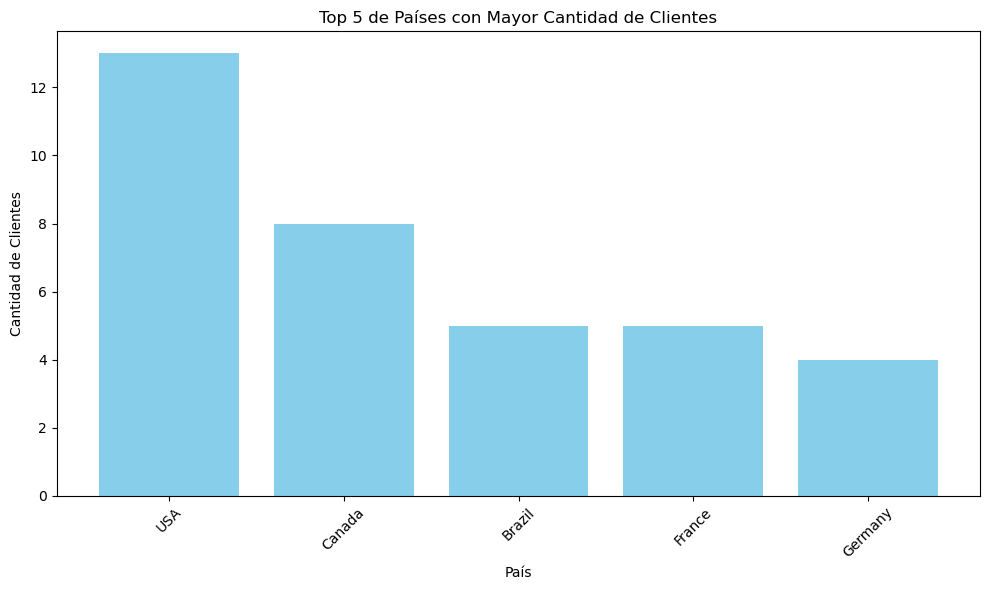

In [12]:
import matplotlib.pyplot as plt

# Crear un gráfico de barras para mostrar el top 5 de países con más clientes
plt.figure(figsize=(10, 6))
plt.bar(df_grouped_by_country_top5['Country'], df_grouped_by_country_top5['client_count'], color='skyblue')

# Etiquetas y título
plt.xlabel('País')
plt.ylabel('Cantidad de Clientes')
plt.title('Top 5 de Países con Mayor Cantidad de Clientes')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor visualización

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Tablas invoicey y InvoiceLine 

De las tablas Invoice y InvoiceLine realice un análisis donde indique:
1 cuales son los 5 tracks más vendidos,
2 los 5 artistas que más venden,
3 el mes donde más ventas se tienen 
4 realice una gráfica con los 5 géneros más vendidos.

In [13]:

# Realiza la consulta SQL para obtener los datos
connection, cursor = connect_to_database()
query_invoice = "SELECT * FROM Invoice"
df_invoice = pd.read_sql(query_invoice, cursor.connection) 

query_invoiceLine = "SELECT * FROM InvoiceLine "
df_invoiceLine  = pd.read_sql(query_invoiceLine, cursor.connection) 

Conexión exitosa a la base de datos.


/tmp/ipykernel_903401/795453065.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_invoice = pd.read_sql(query_invoice, cursor.connection)
/tmp/ipykernel_903401/795453065.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_invoiceLine  = pd.read_sql(query_invoiceLine, cursor.connection)


In [14]:
df_invoice.head()

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2021-01-01,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2021-01-02,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2021-01-03,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2021-01-06,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2021-01-11,69 Salem Street,Boston,MA,USA,2113,13.86


In [15]:
df_invoiceLine.head()

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1


### Los 5 tracks más vendidos

In [16]:
# Agrupar por 'TrackId' y contar cuántas veces se repite cada uno
track_id_quantity = df_invoiceLine.groupby('TrackId')['Quantity'].sum().reset_index(name='TotalQuantity')
track_id_quantity=track_id_quantity.sort_values(by='TotalQuantity',ascending=[False])
# Mostrar el resultado
print(f'los id de los 5 tracks mas vendidos son:\n{track_id_quantity.head(5)}')

los id de los 5 tracks mas vendidos son:
      TrackId  TotalQuantity
1983     3500              2
1297     2263              2
1689     2945              2
1690     2946              2
800      1389              2


###  los 5 artistas que más venden

In [17]:
# Verificar si hay valores None o NaN en la columna 'Total'
contains_none = df_invoice['Total'].isna().any()

# Imprimir el resultado
if contains_none:
    print("La columna 'Total' contiene valores None o NaN.")
else:
    print("La columna 'Total' no contiene valores None o NaN.")

La columna 'Total' no contiene valores None o NaN.


In [18]:
# Agrupar por 'TrackId' y contar cuántas veces se repite cada uno
artis_top = df_invoice.groupby('CustomerId')['Total'].sum().reset_index(name='Total_sales')
artis_top=artis_top.sort_values(by='Total_sales',ascending=[False])
# Mostrar el resultado
print(f'los id de los 5 artistas con mayores ventas son:\n{artis_top.head(5)}')

los id de los 5 artistas con mayores ventas son:
    CustomerId  Total_sales
5            6        49.62
25          26        47.62
56          57        46.62
45          46        45.62
44          45        45.62


### el mes donde más ventas se tienen 

In [19]:
# Verificar si hay valores None o NaN en la columna 'Total'
contains_none = df_invoice['InvoiceDate'].isna().any()

# Imprimir el resultado
if contains_none:
    print("La columna 'InvoiceDate' contiene valores None o NaN.")
else:
    print("La columna 'InvoiceDate' no contiene valores None o NaN.")

La columna 'InvoiceDate' no contiene valores None o NaN.


In [20]:
# Agrupar por 'TrackId' y contar cuántas veces se repite cada uno

df_invoice['month']=df_invoice['InvoiceDate'].dt.month
month_top = df_invoice.groupby('month')['Total'].sum().reset_index(name='Total_sales')
month_top=month_top.sort_values(by='Total_sales',ascending=[False])
# Mostrar el resultado
print(f'los 5 meses con mayores ventas son:\n{month_top.head(5)}')

los 5 meses con mayores ventas son:
   month  Total_sales
0      1       201.12
5      6       201.10
3      4       198.14
7      8       198.10
8      9       196.20


### realice una gráfica con los 5 géneros más vendidos

In [21]:

query = "SELECT * FROM Genre"
df_genere = pd.read_sql(query, cursor.connection) 
df_genere.head()

/tmp/ipykernel_903401/983405541.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_genere = pd.read_sql(query, cursor.connection)


,GenreId,Name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll


In [22]:
df_invoice.columns

Index(['InvoiceId', 'CustomerId', 'InvoiceDate', 'BillingAddress',
       'BillingCity', 'BillingState', 'BillingCountry', 'BillingPostalCode',
       'Total', 'month'],
      dtype='object')

In [23]:
df_invoiceLine.columns

Index(['InvoiceLineId', 'InvoiceId', 'TrackId', 'UnitPrice', 'Quantity'], dtype='object')

In [24]:
connection, cursor = connect_to_database()
query = "SELECT * FROM Track"
df_track = pd.read_sql(query, cursor.connection) 

query = "SELECT * FROM Genre"
df_genere = pd.read_sql(query, cursor.connection) 
df_merge_invoice=pd.merge(df_invoiceLine,
                   df_invoice,
                   on='InvoiceId',
                   how='inner')

Conexión exitosa a la base de datos.


/tmp/ipykernel_903401/2612635741.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_track = pd.read_sql(query, cursor.connection)
/tmp/ipykernel_903401/2612635741.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_genere = pd.read_sql(query, cursor.connection)


In [26]:
df_merge_invoice_track=pd.merge(df_merge_invoice,
                                df_track,
                                on='TrackId',
                                how='inner')
df_invoice_track_genre=pd.merge(df_merge_invoice_track,
                                df_track,
                                on='GenreId',
                                how='inner'    
)


In [27]:
df_invoice_track_genre.columns

Index(['InvoiceLineId', 'InvoiceId', 'TrackId_x', 'UnitPrice_x', 'Quantity',
       'CustomerId', 'InvoiceDate', 'BillingAddress', 'BillingCity',
       'BillingState', 'BillingCountry', 'BillingPostalCode', 'Total', 'month',
       'Name_x', 'AlbumId_x', 'MediaTypeId_x', 'GenreId', 'Composer_x',
       'Milliseconds_x', 'Bytes_x', 'UnitPrice_y', 'TrackId_y', 'Name_y',
       'AlbumId_y', 'MediaTypeId_y', 'Composer_y', 'Milliseconds_y', 'Bytes_y',
       'UnitPrice'],
      dtype='object')

In [28]:




genere_top = df_invoice_track_genre.groupby('Name_x')['Total'].sum().reset_index(name='Total_sales')
genere_top=genere_top.sort_values(by='Total_sales',ascending=[False])
# Mostrar el resultado
print(f'los 5 generos con mayores ventas son:\n{genere_top.head(5)}')

los 5 generos con mayores ventas son:
                         Name_x  Total_sales
485                    Eruption     59065.38
1509        Sure Know Something     42372.99
384          Dazed and Confused     37236.87
1202                      Polly     35952.84
54    Afraid To Shoot Strangers     35952.84
